<a href="https://colab.research.google.com/github/kmjohnson3/Intro-to-MRI/blob/master/NoteBooks/Intro_MRI_Bloch_Solvers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bloch Equation Solvers
This notebook will investigate methods to solve the Bloch-Equations. Recall the Bloch Equations are:

$$\frac{\partial M}{\partial t} = \gamma M \times B $$

where $\gamma$ is the gyromagnetic ratio, $M$ is the magnetization, and $B$ is the magnetic field. It is most common to solve everything in the rotating frame. Where the entire corrdinate system rotates at the Larmor frequency ($\gamma B_0$), such that we only care about the frequency difference from that. There are two types of solvers:


*   Standard differential equation solvers. These solvers use Runge-Kutta or some othe solver to integrate the changes. These solvers are great for RF pulses or short blocks of time with large changes.
*   Nutation solvers. These solvers break the problem into periods of rotation and periods of relaxation. This enables much more computationally efficient solutions. 

This notebooks will show some ways to set this up, starting with the standard differential equation solver.



In [ ]:
# This is comment, Pyhton will ignore this line

# Import libraries (load libraries which provide some functions)
import numpy as np # array library
import matplotlib.pyplot as plt # for plotting
import math
import cmath

# Hit the play button to run this cell

# 1. Standard Solvers

## Bloch Equation Setup
In these solvers, we will use the matrix form of the Bloch equations

\begin{align}
\frac{\partial}{\partial t} \begin{bmatrix}
  M_x \\ M_y \\ M_z
  \end{bmatrix} = \begin{bmatrix}
  -1/T2 & \gamma B_z & -\gamma B_y  \\
   -\gamma B_z & -1/T2 & \gamma B_x \\ 
   \gamma B_y & -\gamma B_x & -1/T1
  \end{bmatrix} \begin{bmatrix}M_x \\ M_y \\ M_z \end{bmatrix} +
  \begin{bmatrix}
  0 \\ 0 \\ M_0/T1
  \end{bmatrix}
\end{align}

This is effectively a rotation about each axis at the rate $\gamma B$, a decay of $M_x$ and $M_y$ at a rate $M_{xy}/T2$, and a recovery of $M_z$ at a rate $(M_0-M_z)/T1$. $M_0$ is assumed to be 1 for simplicity. 

## Solver
The solver will integrate the above equation. This could be done with a simple stepwise solver:
\begin{align}
M_x(t+\Delta t) = M_x(t) + \Delta \frac{\partial M_x(t)}{\partial t}
\end{align}

Where $\Delta$ is a step size and the temporal resolution of the discrete array. However, this method is not fully stable, especially since the derivative of $M_x$ depends on itself. You can very easily find odd conditions, such as the magnetization growing. Instead, more complex methods are needed, which allow for large steps sizes. This is a general issue with numerical solvers and not unique to MRI. 
The below code is a standard Runge-Kutta 4 (RK4) solver for a differential equation. It's essential numerical integration but is much more stable. It achives this stability by evaluating the derivative at the next steps. For more info see [Wikipedia](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)

In [ ]:
from scipy import interpolate

def bloch_solver( B, time, freq, T1=2000, T2=2000, M0=[0,0,1], GAM=42.58e6*2*math.pi):
  # This is simple Rk4 solution to the Bloch Equations.
  #
  # Inputs:
  #   B(array)    -- Magentic Field [N x 3] (T)
  #   time(array) -- Time of each point in waveforms (s)
  #   T1          -- Longitudinal relaxation times (s)
  #   T2          -- Transverse relaxation times (s)
  #   Freq Offset -- Off center frequency in Hz
  #   M0          -- Initial state of magnetization (not equilibrium magnetization)
  # Outputs:
  #   MOutput -- Magnetization for each position in time

  # Convert frequency to rads/s
  act_freq = 2*math.pi*freq

  #Convert to roation rates (gamma*B)
  assert B.shape[1] == 3
  Bx =  GAM*B[:,0]
  By =  GAM*B[:,1]
  Bz =  GAM*B[:,2] + act_freq 

  #Create a spline for interpolation
  spline_Bx = interpolate.splrep(time, Bx)
  spline_By = interpolate.splrep(time, By)
  spline_Bz = interpolate.splrep(time, Bz)

  #Initialize
  Mag = np.array(M0).reshape(3,1)

  # Output storage
  MOutput = np.zeros_like(B)

  #Runge-Kutta PDE Solution
  dt = time[2] - time[1]
  for count, t1 in enumerate(time):
   
    m1 = Mag
  
    bx = interpolate.splev(t1, spline_Bx)
    by = interpolate.splev(t1, spline_By)
    bz = interpolate.splev(t1, spline_Bz)
    k1 = np.array([[  -1/T2,   bz,  -by],
                  [  -bz   ,-1/T2, bx],
                  [   by   , -bx, -1/T1]])@ m1 + np.array([[0],[0],[1/T1]])
  
    t2 = t1 + dt/2
    bx = interpolate.splev(t2, spline_Bx)
    by = interpolate.splev(t2, spline_By)
    bz = interpolate.splev(t2, spline_Bz)
    m2 = Mag + k1*dt/2
    k2 = np.array([[  -1/T2,   bz,  -by],
                  [  -bz   ,-1/T2, bx],
                  [   by   ,  -bx, -1/T1]])@ m2 + np.array([[0],[0],[1/T1]])


    t3 = t1 + dt/2
    bx = interpolate.splev(t3, spline_Bx)
    by = interpolate.splev(t3, spline_By)
    bz = interpolate.splev(t3, spline_Bz)
    m3 = Mag + k2*dt/2
    k3 = np.array([[  -1/T2,   bz,  -by],
                  [  -bz   ,-1/T2, bx],
                  [   by   ,  -bx, -1/T1]])@m3 + np.array([[0],[0],[1/T1]])

    t4 = t1 + dt
    bx = interpolate.splev(t4, spline_Bx)
    by = interpolate.splev(t4, spline_By)
    bz = interpolate.splev(t4, spline_Bz)
    m4 = Mag + k3*dt
    k4 = np.array([[  -1/T2,   bz,  -by],
                  [  -bz   ,-1/T2, bx],
                  [   by   ,  -bx, -1/T1]])@m4 + np.array([[0],[0],[1/T1]])

    # Runge-Kutta averages the above terms  
    Mag = Mag + dt/6*(k1 + 2*k2 + 2*k3 + k4);

    # Save to an array
    MOutput[count,0]= Mag[0]
    MOutput[count,1]= Mag[1]
    MOutput[count,2]= Mag[2]
    
  return MOutput

# Excitation Experiment
This is the most simple experiment with a single excitation pulse followed by recovery. We assume magnetization starts at $M_0 \equiv 1$. We aim to apply an RF pulse to rotate the magnetization into the transverse plane. The amount we rotate the magnetization is the flip angle ($\alpha$). This is equal to:
\begin{equation}
\alpha = \int_{0}^{T_{RF}} \gamma B_1(t) dt
\end{equation}
This assumes the RF pulse is applied along a single axis and more complex relationships do exist for some pulse we won't cover (e.g. adiabatic pulses). The below code will just define a pulse envelope and a phase of the pulse. The phase sets the direction on the $B_1$ field (e.g. along x, y, or mixture).

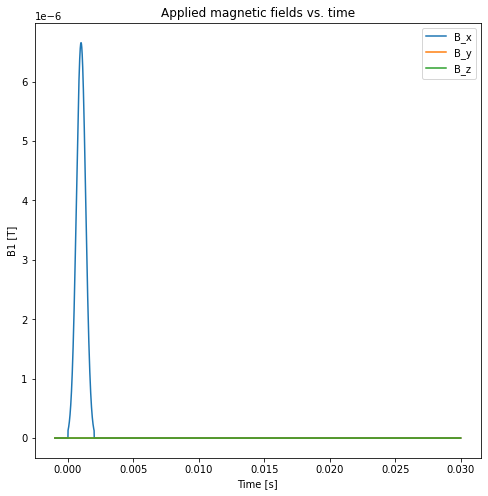

In [ ]:
# Simulation settings
dt = 2e-6 # systems run around 2 us resolution in the rotating frame 
Tmax = 30e-3 #total time to simulate
gamma_bar = 42.58e6
gamma = math.pi*2.0*gamma_bar

# RF Settings
Trf = 2e-3 # period of the pulse
flip = 90 #degrees
excite_phase = 0 # excite phase in degrees

# Define the time span
time = np.arange(-1e-3,Tmax,dt)

# define the RF pulse shape
RF = np.zeros_like(time, dtype=np.complex)
idx = (time<Trf) & (time>=0)
RF[idx] = 1 # Rect function
RF[idx] = np.exp( -16*(time[idx] - Trf/2)**2 / (Trf**2)) # Gaussian

# Now lets scale the RF pulse amplitude to be correct rotation for on-resonance spins
RF = RF*(flip/360) / np.sum(gamma_bar*RF*dt)

#Rotate to the phase of excitation
RF = RF*np.exp(2j*math.pi*excite_phase/360)

# The RF is complex 
B = np.zeros( (len(time),3))
B[:,0] = np.real(RF)
B[:,1] = np.imag(RF)

# Plot
plt.figure(figsize=(8,8))
plt.title('Applied magnetic fields vs. time')
plt.plot(time,B[:,0],label='B_x')
plt.plot(time,B[:,1],label='B_y')
plt.plot(time,B[:,2],label='B_z')
plt.xlabel('Time [s]')
plt.ylabel('B1 [T]')
plt.legend()
plt.show()

# Simulate use the above define solvers

Some things to change:


*   Change T2 to some other values (typical range 1e-3 to 1), does the behavior match what you expect?
*   Change the frequency offset to other values. Why might the Larmor frequency and the RF frequency be slightly different?
*   Change T1 to some other values (typical range 100e-3 to 5), does the behavior match what you expect?



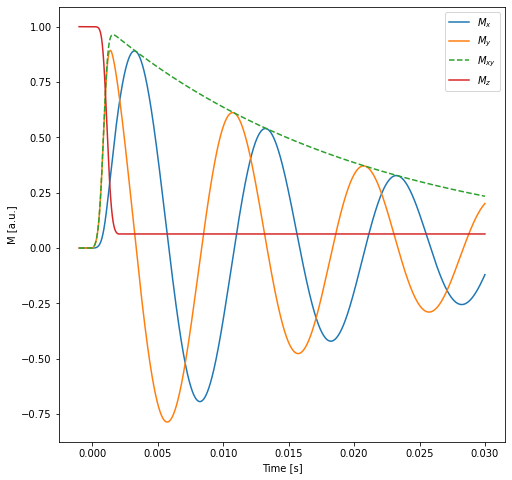

In [ ]:
# B is defined above
# freq = offset frequency from assumed Larmor frequency
# time is defined above
# T1 is the longitudinal relaxation rate
# T2 is the transverse longitudunal rate
Mout = bloch_solver( B, time, freq=100, T1=2000, T2=20e-3)

# Plot
plt.figure(figsize=(8,8))
plt.plot(time,Mout[:,0],label=r'$M_x$')
plt.plot(time,Mout[:,1],label=r'$M_y$')
plt.plot(time,np.sqrt(Mout[:,1]**2+Mout[:,0]**2),'--',label=r'$M_{xy}$')
plt.plot(time,Mout[:,2],label=r'$M_z$')
plt.xlabel('Time [s]')
plt.ylabel('M [a.u.]')
plt.legend()
plt.show()

# 2. Nutation Solvers

## Problem Setup
Nutation solvers break the Bloch equations into events. Events would include RF exitations, times of free recovery, and magnetic field changes from gradients (more on this last one later). The premise of this is that we know the solutions for the Bloch equations analytically. Such solvers can also include traditional solvers for events with unknown equations. Some we know include:



* **Transverse magnetization decay wo/Frequency shift**
\begin{equation}
M_{xy}(t) = M_{xy}(t=0)e^{-t/T2}
\end{equation}

* **Longitudinal magnetization recovery**
\begin{equation}
M_{z}(t) = M_0 + ( M_{z}(t=0)-M_0)e^{-t/T1}
\end{equation}

* **RF pulse at exactly the Larmor frequency**
\begin{equation}
M_xy = R_z(-\theta)R_x(\alpha)R_z(\theta)M
\end{equation}
where $R_z$ is a rotation about $z$, $R_x$ is rotation about $x$, $\alpha$ is the flip angle, and $\theta$ is the phase of the RF pulse.



In [ ]:
class Event:
  def __init__(self, excite_flip=0, excite_phase=0, recovery_time=0, spoil=False):
    self.excite_flip = excite_flip
    self.excite_phase = excite_phase
    self.recovery_time = recovery_time
    self.spoil = spoil

def bloch_nutation_solver( event_list, M0, T1, T2, freq ):

  #  Inputs:
  #    event_list -- Special structure with entries
  #             .excite_flip  flip angle of rotation
  #             .excite_phase phase of excite degrees
  #             .recovery_time time after excite to recover 
  #             .spoil (if 'true' this set the Mxy to zero at the recovery)
  #    T1         -- Longitudinal relaxation times (s)
  #    T2         -- Transverse relaxation times (s)
  #    Freq Offset-- Off center frequency in Hz
  #    M0         -- Initial state of magnetization (not equilibrium magnetization)
  #  Outputs:
  #    time -- Magnetization for each position in time
  #    BOutput -- Magnetic field for each position in time (interpolated)

  # Initialize
  count = 0;
  time = [0,];
  Mout = [M0,]

  M=M0;

  # Go through the event_list
  for event in event_list:
    
    theta = event.excite_phase * math.pi / 180
    alpha =  event.excite_flip * math.pi / 180
    T = event.recovery_time
    spoil = event.spoil
    
    # Excite
    Rz = np.array([[math.cos(theta), math.sin(theta), 0],
                    [-math.sin(theta), math.cos(theta), 0],
                    [0,  0, 1]]) 
    Rx = np.array([[1,0, 0],
                    [0, math.cos(alpha), math.sin(alpha)],
                    [0, -math.sin(alpha), math.cos(alpha)]])
    
    M = np.linalg.inv(Rz)@Rx@Rz@M 
    
    # Relaxation (Transverse)
    if spoil:
        Mxy = 0
    else:
        Mxy = M[0] + 1j*M[1]
        Mxy = Mxy*cmath.exp( 2j*math.pi*freq*T)*math.exp(-T/T2)
            
    # Relaxation (Longitudinal)
    Mz = M[2]
    Mz = 1 + (Mz - 1)*math.exp(-T/T1);
    
    # Put back into [Mx; My; Mz] vector
    M = np.array([[Mxy[0].real], [Mxy[0].imag], [Mz[0]]])
    
    # Store for output
    time.append(time[-1]+T)
    Mout.append(M)

  Mout = np.array(Mout)
  return time, Mout
  

# Example

Here we simulate a situation in which we apply two RF pulses seperated by a gap:

$90 ^{\circ} $ - Delay - $180 ^{\circ}$ - Free recovery

Some experiments to consider:
*   Change the flip angles. 
*   Change the delays (modify the range(100) to a desired delay in ms
*   Change T1 and T2



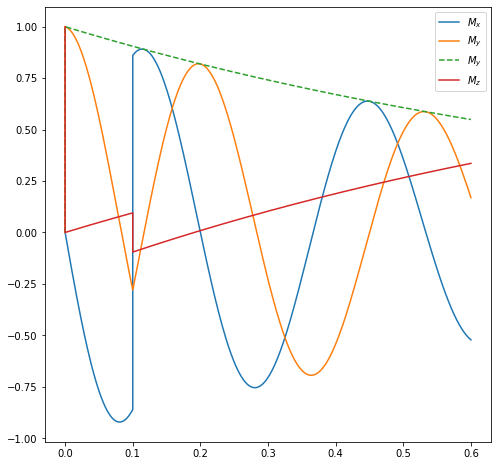

In [ ]:
# Blank list of events
event_list = []

# Excite 90 degree 
event_list.append( Event(excite_flip=90, excite_phase=0))
  
#Recover (100ms,could be one event but plotting possible here)
for pos in range(100):
    event_list.append( Event(recovery_time=1e-3))

# Excite 180 degree
event_list.append( Event(excite_flip=180, excite_phase=90))

#Recover (500ms,could be one event but plotting possible here)
for pos in range(500):
    event_list.append( Event(recovery_time=1e-3))

# Simulate 
M0 = np.array([[0],[0],[1.0]])
T1 = 1
T2 = 1
freq = 3
time,Mout = bloch_nutation_solver( event_list, M0, T1, T2, freq );

plt.figure(figsize=(8,8))
plt.plot(time,Mout[:,0], label=r'$M_x$')
plt.plot(time,Mout[:,1], label=r'$M_y$')
plt.plot(time,np.sqrt(Mout[:,1]**2+Mout[:,0]**2), '--', label=r'$M_y$')
plt.plot(time,Mout[:,2], label=r'$M_z$')
plt.legend()
plt.show()
